#Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

#Data preparation

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt

In [2]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Let us split the images in two groups, according to their label.

In [3]:
"""
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]
"""

'\ncond_1 = cifar10_y_train[:,0] < 5\ncifar10_x_train_1 = cifar10_x_train[cond_1]\ncifar10_y_train_1 = cifar10_y_train[cond_1]\n\ncond_2 = cifar10_y_train[:,0] >= 5\ncifar10_x_train_2 = cifar10_x_train[cond_2]\ncifar10_y_train_2 = cifar10_y_train[cond_2]\n\ncond_1_test = cifar10_y_test[:,0] < 5\ncifar10_x_test_1 = cifar10_x_test[cond_1_test]\ncifar10_y_test_1 = cifar10_y_test[cond_1_test]\n\ncond_2_test = cifar10_y_test[:,0] >= 5\ncifar10_x_test_2 = cifar10_x_test[cond_2_test]\ncifar10_y_test_2 = cifar10_y_test[cond_2_test]\n'

In [4]:
# Split training data into train and validation sets
val_split = 0.1
num_val_samples = int(cifar10_x_train.shape[0] * val_split)

cifar10_x_val = cifar10_x_train[:num_val_samples]
cifar10_y_val = cifar10_y_train[:num_val_samples]

cifar10_x_train = cifar10_x_train[num_val_samples:]
cifar10_y_train = cifar10_y_train[num_val_samples:]

# Separate data into two groups for training
cond_1_train = cifar10_y_train[:, 0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1_train]
cifar10_y_train_1 = cifar10_y_train[cond_1_train]

cond_2_train = cifar10_y_train[:, 0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2_train]
cifar10_y_train_2 = cifar10_y_train[cond_2_train]

# Separate validation data into two groups
cond_1_val = cifar10_y_val[:, 0] < 5
cifar10_x_val_1 = cifar10_x_val[cond_1_val]
cifar10_y_val_1 = cifar10_y_val[cond_1_val]

cond_2_val = cifar10_y_val[:, 0] >= 5
cifar10_x_val_2 = cifar10_x_val[cond_2_val]
cifar10_y_val_2 = cifar10_y_val[cond_2_val]

# Separate test data into two groups
cond_1_test = cifar10_y_test[:, 0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:, 0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]


Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [5]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (Y1_cat[num1],Y2_cat[num2])

    yield x_data, y_data


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [6]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: airplane, second = truck


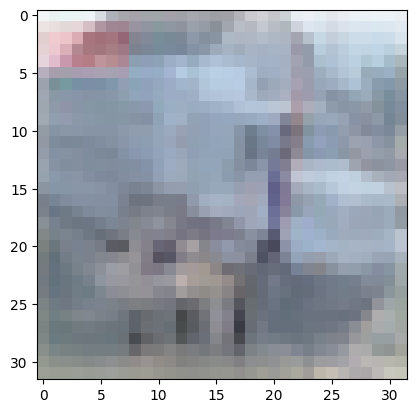

In [7]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Model Evaluation

Let us define first of all the test generator.

In [8]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [9]:
def random_model(x):
  #the random model ingnore the input x and return a pair of random classes
  return(np.random.randint(0,5,(10000,2)))

In [10]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
  correct_guesses_1 = random_guesses[:,0] == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = random_guesses[:,1] == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [11]:
eval_model(random_model)

0.1998

As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [12]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(random_model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mean accuracy =  0.19939999999999997
standard deviation =  0.0013009611831257704


### **Experiment 1:** CNN

In [44]:
"""
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(1.0),
    layers.RandomZoom(1.0),
    layers.RandomContrast(0.5)
])
"""
# Resize CIFAR-10 images to match DenseNet121 input size
resize_layer = layers.Lambda(lambda x: tf.image.resize(x, (32, 32)))

In [14]:
"""
def enhanced_cnn_model():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    #x = data_augmentation(inputs)  # Apply augmentation
    x = resize_layer(inputs)

    # First convolutional block
    #x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    #x = layers.BatchNormalization()(x)
    #x = layers.MaxPooling2D((2, 2))(x)
    shortcut = x
    x = layers.Conv2D(128, (3, 3), padding='same')(inputs)  # No activation here
    #x = layers.LeakyReLU(alpha=0.1)(x)  # Apply LeakyReLU activation
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Adjust shortcut dimensions if necessary
    shortcut = layers.Conv2D(128, (1, 1), padding='same')(shortcut)
    shortcut = layers.MaxPooling2D((2, 2))(shortcut)
    x = layers.Add()([x, shortcut])

    #x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    #x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

     # Adjust shortcut dimensions if necessary
    shortcut = layers.Conv2D(256, (1, 1), padding='same')(shortcut)
    shortcut = layers.MaxPooling2D((2, 2))(shortcut)
    x = layers.Add()([x, shortcut])

    # Additional convolutional block
    #x = layers.Conv2D(384, (3, 3), padding='same')(x)
    #x = layers.LeakyReLU(alpha=0.1)(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.MaxPooling2D((2, 2))(x)

    # Second convolutional block
    #x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    #x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

     # Adjust shortcut dimensions if necessary
    shortcut = layers.Conv2D(512, (1, 1), padding='same')(shortcut)
    shortcut = layers.MaxPooling2D((2, 2))(shortcut)
    x = layers.Add()([x, shortcut])

    #x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(1024, (3, 3), padding='same')(x)
    #x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Add()([x, shortcut])

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)


    # Fully connected layers for output 1
    #fc1_output1 = layers.Dense(1024, activation='relu')(x)
    #fc1_output1 = layers.Dropout(0.5)(fc1_output1)
    #output1 = layers.Dense(5, activation='softmax', name='output1')(fc1_output1)

    # Fully connected layers for output 2
    #fc1_output2 = layers.Dense(1024, activation='relu')(x)
    #fc1_output2 = layers.Dropout(0.5)(fc1_output2)
   #output2 = layers.Dense(5, activation='softmax', name='output2')(fc1_output2)

    # Fully connected layers for output 1 with Leaky ReLU
    fc1_output1 = layers.Dense(1024, activation=None)(x)
    fc1_output1 = layers.LeakyReLU(alpha=0.1)(fc1_output1)
    fc1_output1 = layers.Dropout(0.2)(fc1_output1)
    output1 = layers.Dense(5, activation='softmax', name='output1')(fc1_output1)

    # Fully connected layers for output 2 with Leaky ReLU
    fc1_output2 = layers.Dense(1024, activation=None)(x)
    fc1_output2 = layers.LeakyReLU(alpha=0.1)(fc1_output2)
    fc1_output2 = layers.Dropout(0.2)(fc1_output2)
    output2 = layers.Dense(5, activation='softmax', name='output2')(fc1_output2)

    model = Model(inputs=inputs, outputs=[output1, output2])
    return model

"""

"\ndef enhanced_cnn_model():\n    inputs = tf.keras.Input(shape=(32, 32, 3))\n    #x = data_augmentation(inputs)  # Apply augmentation\n    x = resize_layer(inputs)\n\n    # First convolutional block\n    #x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)\n    #x = layers.BatchNormalization()(x)\n    #x = layers.MaxPooling2D((2, 2))(x)\n    shortcut = x\n    x = layers.Conv2D(128, (3, 3), padding='same')(inputs)  # No activation here\n    #x = layers.LeakyReLU(alpha=0.1)(x)  # Apply LeakyReLU activation\n    x = layers.BatchNormalization()(x)\n    x = tf.keras.activations.swish(x)\n    #x = layers.BatchNormalization()(x)\n    x = layers.MaxPooling2D((2, 2))(x)\n    \n    # Adjust shortcut dimensions if necessary\n    shortcut = layers.Conv2D(128, (1, 1), padding='same')(shortcut)\n    shortcut = layers.MaxPooling2D((2, 2))(shortcut)\n    x = layers.Add()([x, shortcut])\n\n    #x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)\n    x = layers.C

In [45]:
def enhanced_cnn_model():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = resize_layer(inputs)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    x = layers.MaxPooling2D((1, 1))(x)

    # First convolutional block
    #shortcut = x
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    x = layers.MaxPooling2D((1, 1))(x)

    # Downsample shortcut to match x
    #shortcut = layers.Conv2D(128, (1, 1), strides=(2, 2), padding='same')(shortcut)
    #x = layers.Add()([x, shortcut])

    # Second convolutional block
    #shortcut = x
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    x = layers.MaxPooling2D((1, 1))(x)

    # Downsample shortcut to match x
    #shortcut = layers.Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
    #x = layers.Add()([x, shortcut])

    # Third convolutional block
    #shortcut = x
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    x = layers.MaxPooling2D((1, 1))(x)

    # Downsample shortcut to match x
    #shortcut = layers.Conv2D(512, (1, 1), strides=(2, 2), padding='same')(shortcut)
    #x = layers.Add()([x, shortcut])

    # Fourth convolutional block
    #shortcut = x
    x = layers.Conv2D(1024, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.activations.swish(x)
    x = layers.MaxPooling2D((1, 1))(x)

    # Downsample shortcut to match x
    #shortcut = layers.Conv2D(1024, (1, 1), strides=(2, 2), padding='same')(shortcut)
    #x = layers.Add()([x, shortcut])

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layers for output 1
    fc1_output1 = layers.Dense(1024, activation=None)(x)
    fc1_output1 = layers.LeakyReLU(alpha=0.1)(fc1_output1)
    fc1_output1 = layers.Dropout(0.2)(fc1_output1)
    output1 = layers.Dense(5, activation='softmax', name='output1')(fc1_output1)

    # Fully connected layers for output 2
    fc1_output2 = layers.Dense(1024, activation=None)(x)
    fc1_output2 = layers.LeakyReLU(alpha=0.1)(fc1_output2)
    fc1_output2 = layers.Dropout(0.2)(fc1_output2)
    output2 = layers.Dense(5, activation='softmax', name='output2')(fc1_output2)

    model = Model(inputs=inputs, outputs=[output1, output2])
    return model


In [46]:

class LabelSmoothingLoss(tf.keras.losses.Loss):
    def __init__(self, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def call(self, y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_pred)[-1], tf.float32)
        smooth_positives = 1.0 - self.smoothing
        smooth_negatives = self.smoothing / num_classes
        y_true_smoothed = y_true * smooth_positives + smooth_negatives
        return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true_smoothed, y_pred))



In [47]:
# Define learning rate scheduler
initial_lr = 0.001
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps= 5 * 500,  # Assuming 10 epochs
    decay_rate=0.8,
    staircase=True
)

In [48]:
# Define the optimizer with layer-specific learning rates
class CustomAdam(tf.keras.optimizers.Adam):
    def __init__(self, lr_multipliers, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr_multipliers = lr_multipliers

    def _resource_apply_dense(self, grad, var, apply_state=None):
        multiplier = self.lr_multipliers.get(var.name, 1.0)
        scaled_lr = self._get_hyper("learning_rate") * multiplier
        self._set_hyper("learning_rate", scaled_lr)
        return super()._resource_apply_dense(grad, var, apply_state)
"""
# Define learning rate multipliers
lr_multipliers = {
    'conv2d/kernel:0': 1e-5,  # Early layers
    'conv2d_1/kernel:0': 1e-5,
    'conv2d_2/kernel:0': 1e-3,  # Middle layers
    'conv2d_3/kernel:0': 1e-3,
    'dense/kernel:0': 1e-3,  # Final dense layers
    'dense_1/kernel:0': 1e-3
}
"""
lr_multipliers = {
    'conv2d/kernel:0': 1e-5,    # Early layers
    'conv2d_1/kernel:0': 1e-5,  # Early layers
    'conv2d_2/kernel:0': 1e-4,  # Middle layers
    'conv2d_3/kernel:0': 1e-4,  # Middle layers
    'conv2d_4/kernel:0': 1e-3,  # Late layers
    'conv2d_5/kernel:0': 1e-3,  # Late layers
    'dense/kernel:0': 1e-3,     # Final dense layers
    'dense_1/kernel:0': 1e-3
}

# Compile the model with a custom optimizer
custom_optimizer = CustomAdam(
    learning_rate=scheduler,
    lr_multipliers=lr_multipliers
)

In [49]:
model = enhanced_cnn_model()
model.compile(
    optimizer=custom_optimizer,
    loss={'output1': LabelSmoothingLoss(smoothing=0.1), 'output2': LabelSmoothingLoss(smoothing=0.1)},
    metrics={'output1': 'accuracy', 'output2': 'accuracy'}
)

"""
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
    loss={'output1': LabelSmoothingLoss(smoothing=0.1), 'output2': LabelSmoothingLoss(smoothing=0.1)},
    metrics={'output1': 'accuracy', 'output2': 'accuracy'}
)
"""

"""
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
"""

train_gen = datagenerator(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, 64)
val_gen = datagenerator(cifar10_x_val_1, cifar10_x_val_2, cifar10_y_val_1, cifar10_y_val_2, 64)

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=110,
    validation_data=val_gen,
    validation_steps=100
)



Epoch 1/110


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - loss: 2.9897 - output1_accuracy: 0.3653 - output1_loss: 1.5063 - output2_accuracy: 0.3901 - output2_loss: 1.4833 - val_loss: 3.1424 - val_output1_accuracy: 0.3467 - val_output1_loss: 1.5883 - val_output2_accuracy: 0.4300 - val_output2_loss: 1.5541
Epoch 2/110
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 2.6528 - output1_accuracy: 0.4450 - output1_loss: 1.3803 - output2_accuracy: 0.5261 - output2_loss: 1.2725 - val_loss: 2.6278 - val_output1_accuracy: 0.4347 - val_output1_loss: 1.4114 - val_output2_accuracy: 0.5561 - val_output2_loss: 1.2164
Epoch 3/110
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 2.5047 - output1_accuracy: 0.4782 - output1_loss: 1.3313 - output2_accuracy: 0.5862 - output2_loss: 1.1734 - val_loss: 2.8630 - val_output1_accuracy: 0.4022 - val_output1_loss: 1.5289 - val_output2_accuracy: 0.5198 - val_output2_loss: 1.3342
Epoch 4/110
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 2.4190 - output1_accuracy: 0.4999 

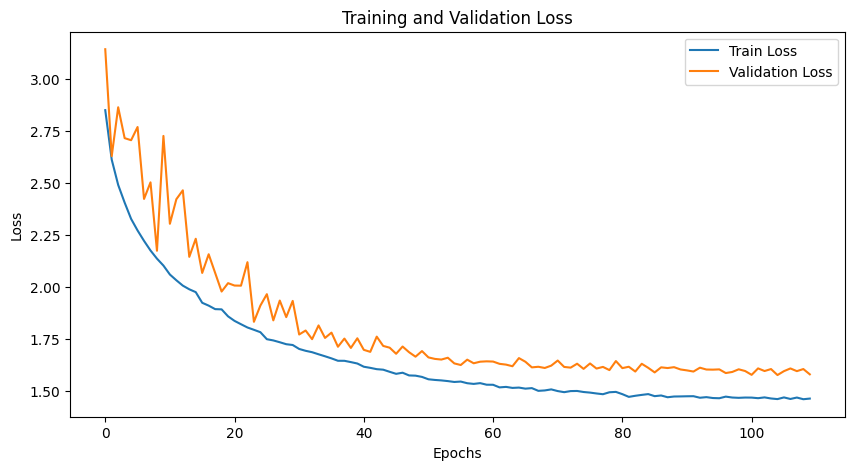

In [50]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
# Save the model weights
model.save_weights("enhanced_cnn_test.weights.h5")

In [52]:
def eval_model(model):
    testgen = datagenerator(cifar10_x_test_1, cifar10_x_test_2, cifar10_y_test_1, cifar10_y_test_2, 10000)
    eval_samples_x, eval_samples_y = next(testgen)
    predictions = model.predict(eval_samples_x)
    pred1 = np.argmax(predictions[0], axis=1)
    pred2 = np.argmax(predictions[1], axis=1)
    correct_guesses_1 = pred1 == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = pred2 == np.argmax(eval_samples_y[1], axis=1)
    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(model))

print("Mean accuracy =", np.mean(eval_results))
print("Standard deviation =", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean accuracy = 0.79357
Standard deviation = 0.003169321693990679


In [ ]:
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
"""

In [ ]:
"""
# Create training and validation data generators
train_gen = datagenerator(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, 64)
val_gen = datagenerator(cifar10_x_val_1, cifar10_x_val_2, cifar10_y_val_1, cifar10_y_val_2, 64)
"""

In [ ]:
"""
# Create the model
inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)

output1 = Dense(5, activation='softmax', name='output1')(x)
output2 = Dense(5, activation='softmax', name='output2')(x)

model = Model(inputs=inputs, outputs=[output1, output2])

# Compile model
epochs = 25  # Number of epochs
lrate = 0.01
decay = lrate / epochs
sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model
steps_per_epoch = cifar10_x_train_1.shape[0] // 64
validation_steps = cifar10_x_val_1.shape[0] // 64

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    verbose=1
)
"""

In [ ]:
"""
# Evaluate the model
def eval_model(model):
    testgen = datagenerator(cifar10_x_test_1, cifar10_x_test_2, cifar10_y_test_1, cifar10_y_test_2, 10000)
    eval_samples_x, eval_samples_y = next(testgen)
    predictions = model.predict(eval_samples_x)
    pred1 = np.argmax(predictions[0], axis=1)
    pred2 = np.argmax(predictions[1], axis=1)
    correct_guesses_1 = pred1 == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = pred2 == np.argmax(eval_samples_y[1], axis=1)
    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(model))

print("Mean accuracy =", np.mean(eval_results))
print("Standard deviation =", np.std(eval_results))
"""

### **`Additional exploration and work:`** For fine-tuning the model Transfer learning can be applied

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
"""
from tensorflow.keras import layers, models

# Resize CIFAR-10 images to match DenseNet121 input size
resize_layer = layers.Lambda(lambda x: tf.image.resize(x, (224, 224)))

# Build the transfer learning model with DenseNet121
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    inputs = layers.Input(shape=(32, 32, 3))
    resized_inputs = resize_layer(inputs)
    x = base_model(resized_inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    # Output branch for classes 0-4
    x1 = layers.Dense(1024, activation='relu')(x)
    x1 = layers.Dropout(0.2)(x1)
    output1 = layers.Dense(5, activation='softmax', name='output1')(x1)

    # Output branch for classes 5-9
    x2 = layers.Dense(1024, activation='relu')(x)
    x2 = layers.Dropout(0.2)(x2)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x2)

    model = models.Model(inputs=inputs, outputs=[output1, output2])
    return model

# Instantiate the model
model = build_model()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
    metrics={'output1': 'accuracy', 'output2': 'accuracy'}
)

# Prepare data generators
train_gen = datagenerator(cifar10_x_train[cifar10_y_train[:, 0] < 5],
                          cifar10_x_train[cifar10_y_train[:, 0] >= 5],
                          cifar10_y_train[cifar10_y_train[:, 0] < 5],
                          cifar10_y_train[cifar10_y_train[:, 0] >= 5], 300)

val_gen = datagenerator(cifar10_x_val[cifar10_y_val[:, 0] < 5],
                        cifar10_x_val[cifar10_y_val[:, 0] >= 5],
                        cifar10_y_val[cifar10_y_val[:, 0] < 5],
                        cifar10_y_val[cifar10_y_val[:, 0] >= 5], 300)

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=500,  # Define appropriate steps based on dataset size
    validation_data=val_gen,
    validation_steps=100,
    epochs=50,
    verbose=1
)

# Save the model
model.save("cifar10_densenet.h5")

# Define eval_model function for evaluation
def eval_model(model):
    testgen = datagenerator(cifar10_x_test_1, cifar10_x_test_2, cifar10_y_test_1, cifar10_y_test_2, 10000)
    eval_samples_x, eval_samples_y = next(testgen)
    predictions = model.predict(eval_samples_x)
    pred1 = np.argmax(predictions[0], axis=1)
    pred2 = np.argmax(predictions[1], axis=1)
    correct_guesses_1 = pred1 == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = pred2 == np.argmax(eval_samples_y[1], axis=1)
    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

# Evaluate the model multiple times
repeat_eval = 10
eval_results = []

for i in range(repeat_eval):
    eval_results.append(eval_model(model))

print("Mean accuracy =", np.mean(eval_results))
print("Standard deviation =", np.std(eval_results))
"""

# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!

